## Projet de Python pour le data scientist (2021-2022)
## "Prédire la gravité des accidents corporels de la route"
### DUJARDIN Thomas, RONDEY Hélène, ROSUNEE Avichaï

<a href="https://colab.research.google.com/github/helene-78/Accidents/blob/main/prep_df_utiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation et chargement des modules

In [1]:
#!pip install imblearn
#!pip install plotly
#!pip install haversine
# !pip install statsmodels #statsmodels, pour utiliser le module de séries temp SARIMAX

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns #Tableau des corrélations
from datetime import date


from imblearn.over_sampling import SMOTE # Pour avoir 50 % de 0 et 50 % de 1 dans la colonne presence_accident
from sklearn.linear_model import LogisticRegression # Regression logistique
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold #KFold répété, pour mieux entraîner le modèle
from sklearn.model_selection import train_test_split


from sklearn import model_selection # Pour utiliser RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier #
from sklearn.model_selection import cross_val_score #Pour mesurer la précision de l'algorithme
from sklearn.metrics import classification_report, confusion_matrix #
from sklearn.utils import shuffle # Pour que le scoring "roc_auc" fonctionne
from sklearn.preprocessing import label_binarize # Transformer y en variable catégorique
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


# ARIMA
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX = modèle de séries temporelles
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

import plotly.express as px # Pour faire des graphes dans l'interface Dash

## Fusion des bases, sélection et reformatage des variables

**Fusion des différents dataframes**

In [3]:
df_accidents = pd.read_csv('Bases de données/caracteristiques-2019.csv', sep=";")
df_usagers = pd.read_csv('Bases de données/usagers-2019.csv', sep=";")
df_lieux = pd.read_csv('Bases de données/lieux-2019.csv', sep=";")
df_vehicules = pd.read_csv('Bases de données/vehicules-2019.csv', sep=";")
df_test = df_accidents.merge(df_usagers.merge(df_lieux.merge(df_vehicules))) #dataframe à traiter

**Pour supprimer les colonnes inutiles à l'analyse de données, supprimer les NaN**

On a choisi d'éliminer les variables : ... car ...

In [4]:
df_utiles = df_test.drop(axis=1, labels=['Num_Acc', 'com', 'adr', 'v1', 'id_vehicule', 'num_veh', 'lartpc', 'larrout', 'occutc', 'v2', 'voie'])
df_utiles = df_utiles.dropna()


**Recodage de la colonne "hrmn" pour exprimer l'heure des accidents en minutes** 

In [5]:
df_utiles["hrmn"] = pd.to_datetime(df_utiles["hrmn"], format='%H:%S')
df_utiles["hrmn"] = df_utiles["hrmn"].apply(lambda x: int(x.hour)*60 + int(x.minute))

**Recodage de la colonne "grav", qui vaudra 1 en cas d'accident mortel, 0 sinon**

In [6]:
df_utiles["hrmn"] = df_utiles["hrmn"].astype('int64')
df_utiles["dep"] = df_utiles["dep"].replace(["2B"], "999") #On remplace les codes des départements de la Corse par des int
df_utiles["dep"] = df_utiles["dep"].replace(["2A"], "998")
df_utiles["actp"] = df_utiles["actp"].replace(["A"], "14") #On remplace les actions du piéton non encodées par des chiffres
df_utiles["actp"] = df_utiles["actp"].replace(["B"], "15")
df_utiles["dep"] = df_utiles["dep"].astype('int64')
df_utiles["grav"] = df_utiles["grav"].apply(lambda x: int(x==2)) # On recode la colonne "grav" : tué = 1, blessé léger/hospitalisé/indemne = 0

In [7]:
# Pour avoir les coordonnées GPS en float, sinon plotly.express (px) ne peut pas les afficher sur la carte de France
df_utiles['lat'] = df_utiles['lat'].str.replace(',', '.').astype(float)
df_utiles['long'] = df_utiles['long'].str.replace(',', '.').astype(float)



In [9]:
# On recode catv pour regrouper les véhicules en catégories:
# 1 : véhicules légers (VL, VU)
# 2 : Sans permis (< 125 cm3)
# 3 : Poids lourds
# 4 : transports en commun
# 5 : > 125 cm3

def func(x):
    if x in [7,10]:
        x=1; 
    elif (x in [1, 2, 3, 30, 31, 32, 50, 60, 80, 99, 35, 41, 42]):
        x=2; 
    elif (x in [13, 14, 15, 16, 17, 20, 21]) :
        x=3 
    elif (x in  [37, 38, 39, 40])  :
        x= 4 
    elif (x in [33, 34, 36, 43]) : #voir dans la description si on peut mettre un else à la place
        x= 5 
    return x

        
df_utiles['catv'] = df_utiles['catv'].apply(func)


In [10]:
# La dépendance de "grav" en "an_nais" (mortalité en fct de l'année de naissance) est a priori non linéaire, on utilise alors
# an_nais²

df_utiles['an_nais_carre'] = df_utiles['an_nais'].apply(lambda x: x*x)
df_utiles['an_nais_carre']

0         4008004
1         3972049
2         3837681
3         3976036
4         3984016
           ...   
132972    3952144
132973    3992004
132974    3916441
132975    3896676
132976    3884841
Name: an_nais_carre, Length: 132977, dtype: int64

In [1]:
df_utiles.to_csv('df_utiles.csv')

NameError: name 'df_utiles' is not defined

In [14]:
df_utiles.head()

,jour,mois,an,hrmn,lum,dep,agg,int,atm,col,...,situ,vma,senc,catv,obs,obsm,choc,manv,motor,an_nais_carre
0,30,11,2019,60,4,93,1,1,1,2,...,1,70,2,1,0,2,5,23,1,4008004
1,30,11,2019,60,4,93,1,1,1,2,...,1,70,2,1,0,2,5,23,1,3972049
2,30,11,2019,60,4,93,1,1,1,2,...,1,70,2,3,1,0,3,11,1,3837681
3,30,11,2019,120,3,93,1,1,1,6,...,1,70,1,1,4,0,1,0,1,3976036
4,28,11,2019,900,1,92,1,1,1,4,...,1,90,1,1,0,2,1,2,1,3984016


In [15]:
df_utiles.dtypes

jour               int64
mois               int64
an                 int64
hrmn               int64
lum                int64
dep                int64
agg                int64
int                int64
atm                int64
col                int64
lat              float64
long             float64
place              int64
catu               int64
grav               int64
sexe               int64
an_nais            int64
trajet             int64
secu1              int64
secu2              int64
secu3              int64
locp               int64
actp              object
etatp              int64
catr               int64
circ               int64
nbv                int64
vosp               int64
prof               int64
pr                object
pr1               object
plan               int64
surf               int64
infra              int64
situ               int64
vma                int64
senc               int64
catv               int64
obs                int64
obsm               int64


In [16]:
df_utiles.columns # Liste des colonnes

Index(['jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'agg', 'int', 'atm', 'col',
       'lat', 'long', 'place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet',
       'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp', 'catr', 'circ',
       'nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'surf', 'infra', 'situ',
       'vma', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor',
       'an_nais_carre'],
      dtype='object')

In [17]:
df_utiles.describe()

,jour,mois,an,hrmn,lum,dep,agg,int,atm,col,...,situ,vma,senc,catv,obs,obsm,choc,manv,motor,an_nais_carre
count,132977.000000,132977.000000,132977.0,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,...,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,1.329770e+05
mean,15.679546,6.701587,2019.0,811.744587,1.932710,113.289840,1.622596,2.016552,1.614279,3.890071,...,1.328350,61.545861,1.560819,1.612497,1.120036,1.543244,2.912804,7.202343,1.149943,3.921083e+06
std,8.746306,3.385577,0.0,329.302835,1.495194,221.949146,0.484739,1.982705,1.672985,1.862988,...,1.135905,25.020834,0.832060,1.201753,3.263113,1.089174,2.391689,8.113968,1.054699,7.567956e+04
min,1.000000,1.000000,2019.0,0.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3.610000e+06
25%,8.000000,4.000000,2019.0,540.000000,1.000000,34.000000,1.000000,1.000000,1.000000,3.000000,...,1.000000,50.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.869089e+06
50%,16.000000,7.000000,2019.0,840.000000,1.000000,69.000000,2.000000,1.000000,1.000000,3.000000,...,1.000000,50.000000,1.000000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000,3.932289e+06
75%,23.000000,10.000000,2019.0,1080.000000,3.000000,87.000000,2.000000,2.000000,1.000000,6.000000,...,1.000000,80.000000,2.000000,2.000000,0.000000,2.000000,4.000000,15.000000,1.000000,3.980025e+06
max,31.000000,12.000000,2019.0,1380.000000,5.000000,999.000000,2.000000,9.000000,9.000000,7.000000,...,8.000000,800.000000,3.000000,5.000000,17.000000,9.000000,9.000000,26.000000,6.000000,4.076361e+06


In [20]:
df_utiles["sexe"].describe()

count    132977.000000
mean          1.320304
std           0.466595
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: sexe, dtype: float64

68% des accidents sont causés par des hommes

## Partie descriptive

#### Analyse statistique des données de df_utiles.csv : matrice des corrélations 

<AxesSubplot:>

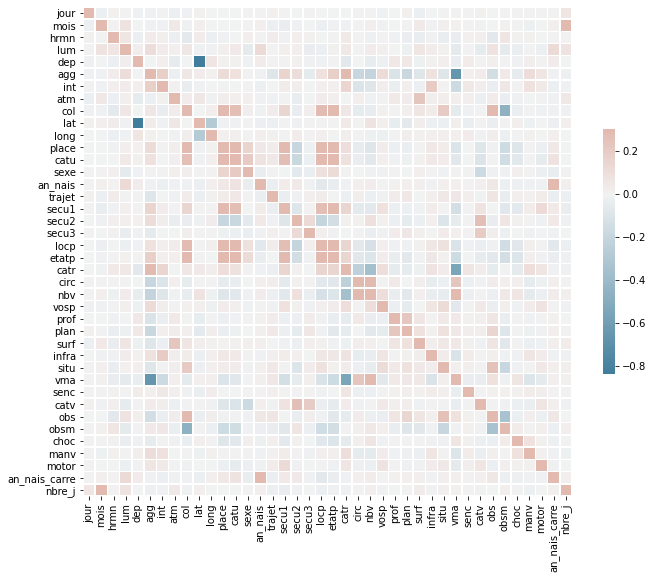

In [25]:
correl = df_utiles.drop(['an', 'grav'], axis=1).corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correl, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

on observe par exemple que la vitesse maximale autorisée sur le lieu et au moment de l’accident (vma) est postivement corrélée au nombre total de voies de circulation (nbv)

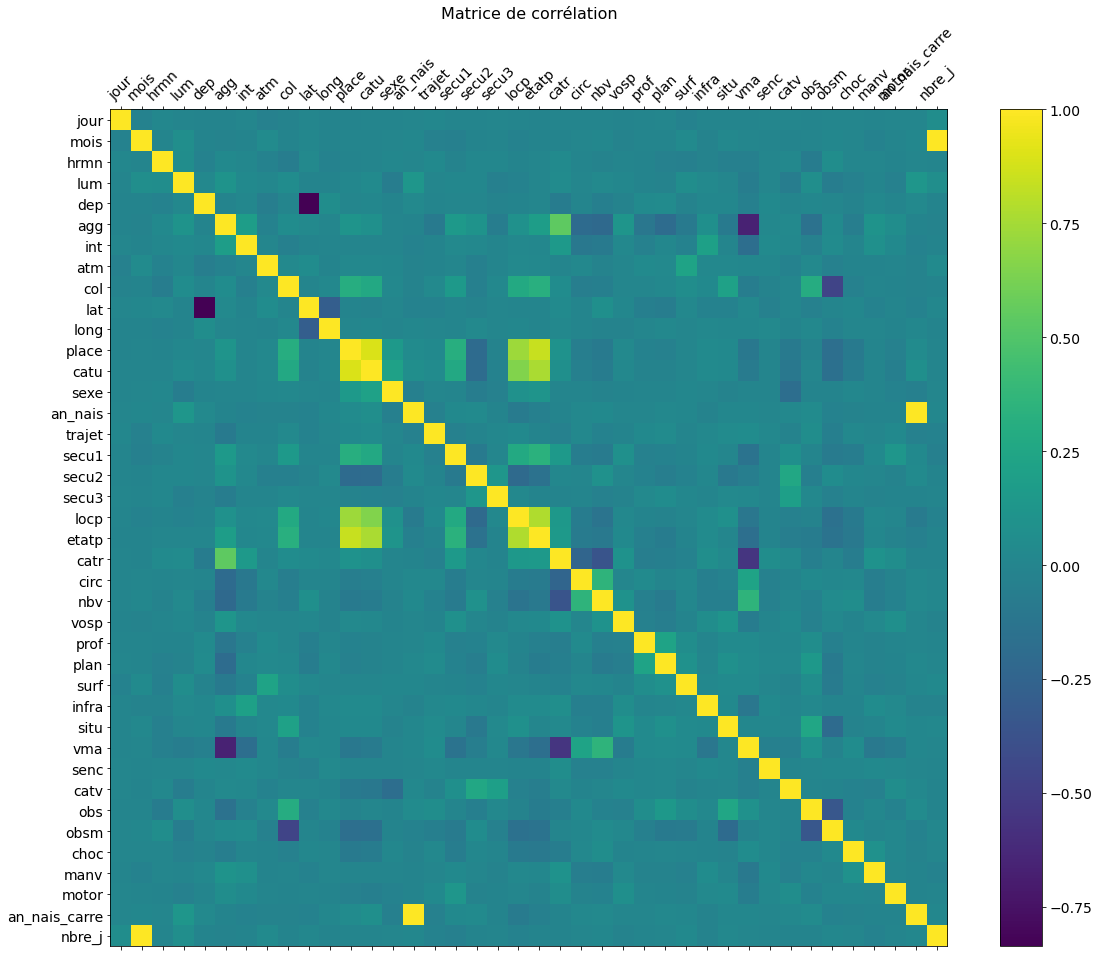

In [27]:
f = plt.figure(figsize=(19, 15))
plt.matshow(correl, fignum=f.number)
plt.xticks(range(correl.shape[1]), correl.columns, fontsize=14, rotation=45)
plt.yticks(range(correl.shape[1]), correl.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Matrice de corrélation', fontsize=16);

In [29]:
correl.corr().style.background_gradient(cmap='coolwarm')

,jour,mois,hrmn,lum,dep,agg,int,atm,col,lat,long,place,catu,sexe,an_nais,trajet,secu1,secu2,secu3,locp,etatp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,senc,catv,obs,obsm,choc,manv,motor,an_nais_carre,nbre_j
jour,1.000000,-0.028378,0.000397,-0.046516,-0.020167,-0.039000,-0.026822,-0.093910,-0.078221,0.019793,-0.036506,-0.072709,-0.072906,-0.035350,-0.033026,-0.009662,-0.063540,-0.011742,-0.016982,-0.066390,-0.070182,-0.036689,-0.012713,-0.007282,-0.063874,-0.033111,-0.009796,-0.092910,-0.053663,-0.042711,0.019901,-0.025373,-0.008813,-0.040670,0.035762,-0.002989,-0.028391,-0.024650,-0.033128,0.032289
mois,-0.028378,1.000000,-0.033507,0.095778,-0.022346,-0.067869,-0.071526,0.056087,-0.090006,0.029815,-0.049464,-0.102930,-0.101067,-0.038303,-0.028643,-0.098885,-0.161498,-0.037799,-0.056141,-0.116442,-0.105015,-0.070504,-0.001020,0.021281,-0.089114,-0.041572,-0.029157,0.040417,-0.095313,-0.027594,0.046924,-0.050114,-0.064228,-0.045399,0.042910,-0.013935,-0.093444,-0.059137,-0.028794,0.998159
hrmn,0.000397,-0.033507,1.000000,0.071459,-0.062875,0.076848,0.016489,-0.097240,-0.186059,0.069405,-0.079696,-0.076962,-0.075526,-0.006635,-0.028878,0.018276,-0.075333,0.034351,-0.017000,-0.072251,-0.057293,0.066399,-0.041215,-0.052167,-0.027274,-0.069000,-0.114297,-0.133669,-0.058874,-0.152061,-0.081789,-0.013129,0.008568,-0.196983,0.169666,0.003114,0.000919,-0.032028,-0.028919,-0.033553
lum,-0.046516,0.095778,0.071459,1.000000,0.031600,0.154816,0.027963,-0.017704,0.056408,-0.016894,-0.045469,-0.023760,-0.007451,-0.139009,0.216164,-0.053975,-0.014786,-0.005339,-0.133870,-0.070553,-0.032287,0.085548,-0.050988,-0.021765,-0.010773,-0.068547,-0.080510,0.070663,0.010275,-0.016194,-0.127153,-0.034339,-0.134071,0.090385,-0.107283,-0.111270,-0.033050,-0.096851,0.216035,0.093661
dep,-0.020167,-0.022346,-0.062875,0.031600,1.000000,-0.022940,0.022928,-0.113277,-0.001978,-0.970056,0.269349,0.005511,0.009310,-0.024828,0.055237,0.017643,0.002481,0.012325,-0.023706,-0.011471,-0.003197,-0.073914,-0.013420,-0.097924,-0.051274,0.098154,0.113208,-0.049457,0.027714,0.028180,-0.035123,0.070585,-0.006194,0.043312,-0.004217,-0.034288,0.042630,-0.000386,0.055221,-0.023612
agg,-0.039000,-0.067869,0.076848,0.154816,-0.022940,1.000000,0.407020,-0.085360,0.106110,0.031139,-0.014615,0.241851,0.210180,0.007989,-0.058615,-0.183769,0.374047,0.096071,-0.117420,0.255101,0.326937,0.867194,-0.517653,-0.550453,0.226600,-0.272409,-0.361866,-0.201097,0.216990,-0.149749,-0.928992,0.051771,0.046363,-0.304011,0.059016,-0.173625,0.237978,0.133617,-0.058162,-0.070203
int,-0.026822,-0.071526,0.016489,0.027963,0.022928,0.407020,1.000000,-0.046049,-0.103223,-0.018180,-0.029269,-0.032597,-0.046735,-0.039637,-0.106390,-0.074898,0.060349,0.042343,-0.057985,0.001059,0.008097,0.375371,-0.327936,-0.305128,0.045894,-0.130200,-0.072199,-0.121044,0.384194,-0.077931,-0.417964,0.075908,0.022464,-0.160489,0.124764,-0.050527,0.191259,0.076971,-0.106472,-0.073221
atm,-0.093910,0.056087,-0.097240,-0.017704,-0.113277,-0.085360,-0.046049,1.000000,0.027872,0.112658,-0.058267,-0.012167,-0.014884,0.004792,-0.086176,-0.053064,-0.052990,-0.115561,-0.051474,0.000857,-0.015170,-0.048534,0.010869,-0.030086,-0.048067,0.057858,0.045320,0.416216,-0.004551,0.022569,0.050618,-0.020855,-0.103688,0.045955,-0.076508,-0.048011,-0.068197,-0.051795,-0.086177,0.050860
col,-0.078221,-0.090006,-0.186059,0.056408,-0.001978,0.106110,-0.103223,0.027872,1.000000,-0.015659,0.015123,0.573682,0.557985,0.108942,-0.076939,0.036318,0.385954,-0.270419,-0.016951,0.578034,0.574188,0.147213,-0.184172,-0.228392,-0.018734,-0.030555,0.022982,0.077858,0.050579,0.408203,-0.154117,-0.077682,-0.096725,0.482336,-0.794590,-0.191356,-0.037013,-0.070545,-0.075683,-0.094568
lat,0.019793,0.029815,0.069405,-0.016894,-0.970056,0.031139,-0.018180,0.112658,-0.015659,1.000000,-0.452157,-0.015195,-0.019785,0.015708,-0.053231,-0.045739,-0.005118,-0.011629,0.011295,-0.002533,-0.003084,0.057022,0.015449,0.120100,0.050742,-0.102635,-0.133587,0.046966,-0.041

**Test des séries temporelles ARIMA pour anticiper le nombre d'accidents**

**But : obtenir la colonne nbre_acc_j qui représente le nombre d'accidents par jour**

In [ ]:
#Formatage de 
# la colonne "jour_format_normal" contient la date au format standard dd/mm/yyyy
df_utiles["jour_format_normal"] = df_utiles["jour"].astype(str)+'/'+df_utiles["mois"].astype(str)+'/'+df_utiles["an"].astype(str)
df_utiles["jour_format_normal"] = pd.to_datetime(df_utiles["jour_format_normal"], format="%d/%m/%Y")
df_utiles["colonne_soustraction"] = date(df_utiles["an"].iloc[0], 1, 1) # Création d'une colonne remplie avec la date du 01/01/2019
df_utiles["colonne_soustraction"] = pd.to_datetime(df_utiles["colonne_soustraction"]) #Pour transformer en objet date 
df_utiles["nbre_j"] = df_utiles["jour_format_normal"] - df_utiles["colonne_soustraction"] # Permet d'obtenir une colonne contenant, pour chaque accident,
# Le nombre de jours écoulés depuis le 01/01/2019


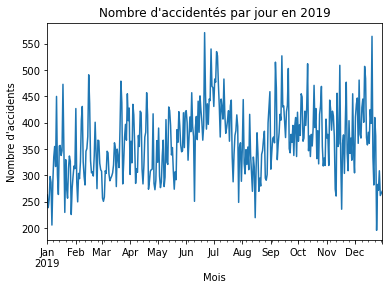

In [16]:

def datification(x):
    return x.days # Permet d'obtenir l'entier contenu par l'objet "date" de Python
df_utiles["nbre_j"] = df_utiles["nbre_j"].apply(datification) #Maintenant nbre_j est une colonne d'entiers
nbre_acc_j = df_utiles.groupby(['nbre_j']).agg('count').jour.values #Nbre d'accidents (ou de victimes d'accidents jsp) par jour
ts = pd.Series(nbre_acc_j, index=pd.date_range("1/1/2019", periods=365)) # Objet Series de pandas, pour faire des graphes
plt.title("Nombre d'accidentés par jour en 2019")
plt.xlabel('Mois')
plt.ylabel("Nombre d'accidents")
ts.plot()

On observe de pics significatifs : le premier vers mi-juin qui pourrait correspondre aux départs massifs en vacances ce qui entraîne inévitablement un plus grand nombre d'accident, et le deuxième vers mi-décembre qui pourrait être lié aux intempéries et à la météo moins favorable en hiver.

#### Graphe d'autocorrélation 

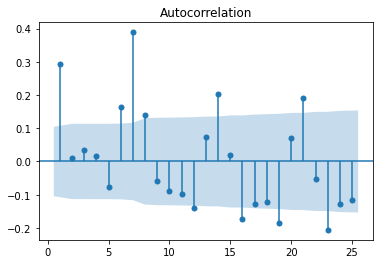

In [30]:
# Subtract the rolling mean
nbre_acc_j_dataframe = pd.DataFrame(nbre_acc_j)
nbre_acc_rolling = nbre_acc_j_dataframe - nbre_acc_j_dataframe.rolling(15).mean()

# On retire les valeurs NaN
nbre_acc_rolling = nbre_acc_rolling.dropna() 

# On dessine le graphe
fig, ax1 = plt.subplots() 
plot_acf(nbre_acc_rolling, lags=25, zero=False, ax=ax1);

Conclusion : la composante saisonale a pour période 7 (abscisse du max sur le plot ci-dessus)

**SARIMAX : prédire le nombre d'accidents en s'appuyant sur les données déjà enregistrées**

In [31]:
# Création du modèle Sarimax
model = SARIMAX(nbre_acc_j, order=(31, 0, 0), seasonal_order=(1, 1, 0, 32)) # Le 7 correspond à la période déterminée ci-dessus

# Fit du modèle
results = model.fit()

# Affichage du résumé des résultats
results.summary()

D:\Programmes\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  365
Model:             SARIMAX(31, 0, 0)x(1, 1, 0, 32)   Log Likelihood               -1799.521
Date:                             Thu, 06 Jan 2022   AIC                           3665.043
Time:                                     11:01:29   BIC                           3790.711
Sample:                                          0   HQIC                          3715.154
                                             - 365                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2515      0.063      3.970      0.000       0.127       0.376
ar.L2          0.0990      0.063      1.583      0.114      -0.024       0.222
ar.L3          0.0923      0.068      1.367      0.172      -0.040       0.225
ar.L4          0.0954      0.065      1.459      0.145      -0.033       0.223
ar.L5          0.0272      0.062      0.439      0.661      -0.094       0.149
ar.L6          0.0330      0.063      0.525      0.599      -0.090       0.156
ar.L7          0.3552      0.060      5.924      0.000       0.238       0.473
ar.L8         -0.0019      0.064     -0.030      0.976      -0.127       0.123
ar.L9          0.0190      0.063      0.300      0.764      -0.105       0.143
ar.L10         0.0073      0.068      0.107      0.914      -0.125       0.140
ar.L11        -0.0632      0.066     -0.955      0.340      -0.193       0.066
ar.L12        -0.0742      0.068     -1.087      0.277      -0.208       0.060
ar.L13         0.0682      0.062      1.102      0.271      -0.053       0.190
ar.L14        -0.0076      0.063     -0.121      0.904      -0.131       0.115
ar.L15        -0.0384      0.066     -0.579      0.562      -0.168       0.091
ar.L16        -0.0695      0.064     -1.089      0.276      -0.195       0.056
ar.L17        -0.0519      0.066     -0.786      0.432      -0.181       0.078
ar.L18         0.1215      0.064      1.891      0.059      -0.004       0.247
ar.L19        -0.1307      0.075     -1.737      0.082      -0.278       0.017
ar.L20         0.1135      0.075      1.522      0.128      -0.033       0.260
ar.L21         0.1028      0.067      1.535      0.125      -0.028       0.234
ar.L22        -0.1468      0.072     -2.037      0.042      -0.288      -0.006
ar.L23        -0.1087      0.068     -1.587      0.112      -0.243       0.026
ar.L24         0.1061      0.069      1.536      0.125      -0.029       0.241
ar.L25        -0.0762      0.069     -1.102      0.270      -0.212       0.059
ar.L26         0.0208      0.078      0.268      0.789      -0.131       0.173
ar.L27        -0.0294      0.070     -0.417      0.677      -0.168       0.109
ar.L28         0.1748      0.072      2.439      0.015       0.034       0.315
ar.L29         0.0358      0.068      0.529      0.597      -0.097       0.168
ar.L30         0.0119      0.067      0.178      0.859      -0.120       0.144
ar.L31        -0.2214      0.064     -3.450      0.001      -0.347      -0.096
ar.S.L32      -0.4561      0.063     -7.193      0.000      -0.580      -0.332
sigma2      2748.4870    216.150     12.716      0.000    2324.841    3172.133
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 4.24
Prob(Q):                              0.73   Prob(JB):                         0.12
Heteroskedasticity (H):     

In [19]:
results_pred = results.get_forecast(31) #Utilise le modèle précédent afin de prédire 31 nouvelles valeurs (mois de janvier 2020)
results_mean = results_pred.predicted_mean #Je ne sais pas trop
results_mean = pd.DataFrame(results_mean) #En objet dataframe
results_final = nbre_acc_j_dataframe.append(results_mean) #On adjoint les 31 prédictions aux valeurs réelles afin de tout afficher
results_final = results_final.reset_index() #Après cette fusion de dataframe, l'index est cassé, on le réinitialise donc
results_final = results_final.drop("index", axis=1) #La commande précédent ajoute une colonne "index" inutile dans le DataFrame, on la supprime
date_index = pd.date_range('1/1/2019', periods=396, freq='D') #Pour avoir les dates en abscisse (365 + 31 = 396 jours)
results_final = results_final.set_index(date_index)
print(results_final)

                     0
2019-01-01  263.000000
2019-01-02  239.000000
2019-01-03  255.000000
2019-01-04  298.000000
2019-01-05  287.000000
...                ...
2020-01-27  300.294077
2020-01-28  303.277792
2020-01-29  323.448099
2020-01-30  362.116888
2020-01-31  305.975225

[396 rows x 1 columns]


Comparer avec les données pratiques de 2020 et si ce n'est pas proche, expliquer

## Partie carte

# Récupération des frontières des régions françaises

In [20]:
#Au cas où la cellule suivante ne marche pas
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [21]:
fr_regions = pd.read_json('https://france-geojson.gregoiredavid.fr/repo/regions.geojson')
fr_regions = fr_regions.to_json()

 # Les frontières des régions françaises (en geojson) sont stockées dans fr_regions

Faire une carte de la France avec densité des accidents et tracé des régions

## Partie prédiction

Ne pas tenir compte de cette cellule

In [22]:
variables_utiles_regr = ['nbre_j', 'hrmn', 'lum', 'lat', 'long', 'agg', 'int', 'atm', 'col', 'catr', 'prof', 'plan', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe', 'grav', 'an_nais']
variables_utiles_regr_sans_grav = ['nbre_j', 'hrmn', 'lum', 'lat', 'long', 'agg', 'int', 'atm', 'col', 'catr', 'prof', 'plan', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe', 'an_nais']


# A faire : vérifier que les données sont centrées-réduites
# A faire : changer les différents paramètres pour tester

df_rayon = []
df_rayon = df_utiles[variables_utiles_regr] # On ne retient que les variables utiles
df_rayon = pd.DataFrame(df_rayon)

X = df_rayon[variables_utiles_regr_sans_grav] # Tout le dataframe sans la colonne "grav" qu'on cherche à prédire
y = df_rayon.grav #colonne "grav"
X, y = shuffle(X, y)
X = pd.DataFrame(X)

y = y.astype(int) #Pour s'assurer que y est une colonne d'int
y = label_binarize(y, classes=[0, 1]) #Pour faire du one-hot encoding sur y
y = pd.DataFrame(y)

os = SMOTE(random_state=0) #Initialisation de SMOTE, pour avoir 50 % de 0 et 50 % de 1 dans y (sans modifier la distribution de l'échantillon d'accidents)
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1) #K-Fold répété, augmente la précision de l'algo de ~10 %
for train_index, test_index in cv.split(X): #On remplit X_train, X_test, Y_train et Y_test pour fitter et tester l'algo
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
rfc = RandomForestClassifier() # On charge une instance de RandomForestClassifier
rfc.fit(X_train,y_train) #On fit sur l'ensemble d'entraînement
rfc_predict = rfc.predict(X_test) #On teste
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc') #On évalue le score
cm = confusion_matrix(y_test.values.argmax(axis=1), rfc_predict.argmax(axis=1))
precision = (cm[0][0] + cm[1][1])/(cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
precision2 = accuracy_score(y_test, rfc_predict) # Même chose que la variable precision

def random_forest(pred):
    return [precision2*100, rfc.predict(pred)]

<ipython-input-22-45d3c1dee8ca>:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train) #On fit sur l'ensemble d'entraînement
C:\Users\avich\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\avich\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\avich\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expec

AxisError: axis 1 is out of bounds for array of dimension 1

Virer les lignes redondantes

In [23]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
import pickle # Pour sauvegarder le modèle de OneHotEncoding

variables_utiles_regr = ['an_nais_carre', 'nbre_j', 'hrmn', 'lum', 'lat', 'long', 'agg', 'int', 'atm', 'catr', 'prof', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe', 'grav', 'an_nais']
variables_utiles_regr_sans_grav = ['an_nais_carre', 'nbre_j', 'hrmn', 'lum', 'lat', 'long', 'agg', 'int', 'atm', 'catr', 'prof', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe', 'an_nais']
variables_utiles_cat = ['lum', 'agg', 'int', 'atm', 'catr', 'prof', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe']
variables_utiles_num = ['nbre_j', 'hrmn', 'lat', 'long', 'an_nais', 'an_nais_carre']
   
df_keras = df_utiles[variables_utiles_regr] # On ne retient que les variables utiles
df_keras = pd.DataFrame(df_keras)
enc = OneHotEncoder(handle_unknown='ignore') #OneHotEncoder pour les variables catégorielles
ss = StandardScaler() #Permet de rendre les variables numériques centrées et réduites

for var in variables_utiles_cat: # On parcourt les variables utiles catégorielles
    df_keras[var] = enc.fit_transform(df_keras[var].values.reshape(-1, 1)).todense()
pickle.dump(enc, open('onehot.pickle', 'wb')) #Permet de transformer et sauvegarder les entrées en vecteurs encodés de la même manière que les variables catégorielles avec l'Encoder

for var in variables_utiles_num:
    df_keras[var] = ss.fit_transform(df_keras[var].values.reshape(-1, 1))
pickle.dump(ss, open('standardscaler.pickle', 'wb')) #idem que variables catégorielles et l'encodeur

#On chercher à prédire y (grav) à partir des variables explicatives X
X = df_keras[variables_utiles_regr_sans_grav] # Tout le dataframe sans la colonne "grav" qu'on cherche à prédire
y = df_keras.grav #colonne "grav"
y = y.astype(int) #Pour s'assurer que y est une colonne d'int
y = label_binarize(y, classes=[0, 1]) #Pour faire du one-hot encoding sur y
y = pd.DataFrame(y) #car y est devenu un np.array 

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) #K-Fold répété, augmente la précision de l'algo de ~10 %

os = SMOTE(sampling_strategy=0.1) # Pour rééqulibrer l'échantillon (2,63 % d'accidents mortels), crée artificiellement des données
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', os), ('u', under)]
pipeline = Pipeline(steps=steps)
# Appliquer la pipeline précédente aux données
columns = X.columns
X, y = pipeline.fit_resample(X, y)
X = pd.DataFrame(data=X,columns=columns)
y= pd.DataFrame(data=y)

for train_index, test_index in cv.split(X): #On remplit X_train, X_test, Y_train et Y_test pour fitter et tester l'algo
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
# Réseaux de neurones
    
model = Sequential()  #Création du modèle, neurone à neurone. fonction d'activation "relu " = partie positive (x -> max(x, 0))
model.add(Dense(256, input_dim=21, activation='relu'))  # variables_utiles_regr_sans_grav contient 22 variables #Il y a 256 neurones sur la couche
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu')) #128 neurones sur la deuxième couche
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) 
model.add(Flatten())
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=64)
predictions = model.predict(X_test)
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/5
547/547 [==============================] - 5s 5ms/step - loss: 0.5540 - accuracy: 0.7160
Epoch 2/5
547/547 [==============================] - 3s 5ms/step - loss: 0.5283 - accuracy: 0.7318
Epoch 3/5
547/547 [==============================] - 3s 5ms/step - loss: 0.5255 - accuracy: 0.7356
Epoch 4/5
547/547 [==============================] - 3s 5ms/step - loss: 0.5216 - accuracy: 0.7354
Epoch 5/5
122/122 [==============================] - 1s 3ms/step - loss: 0.4937 - accuracy: 0.7505
Accuracy: 75.05


## On obtient environ 75% de précision avec le réseau de neurones

In [24]:
def output_NN_Keras(output):
    if output[0][0] > 0.5:
        return 'Décès'
    else:
        return 'Survie'

def NN_Keras(pred):
    pred = np.asarray(pred).astype('float32')
    pred = pd.DataFrame(np.reshape(pred, (1, -1)), columns=[['nbre_j', 'hrmn', 'lat', 'long', 'an_nais', 'lum', 'agg', 'int', 'atm', 'catr', 'prof', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe']])
    pred['an_nais_carre'] = pred['an_nais']*pred['an_nais']
    loaded_enc = pickle.load(open("onehot.pickle", "rb"))
    loaded_ss = pickle.load(open("standardscaler.pickle", "rb"))
    for var in variables_utiles_cat: # On parcourt les variables utiles catégorielles
        pred[var] = np.array(loaded_enc.fit_transform(pred[var].values.reshape(-1, 1)).todense())
    for var in variables_utiles_num: # On parcourt les variables utiles catégorielles
        pred[var] = loaded_ss.fit_transform(pred[var].values.reshape(-1, 1))
    return [accuracy*100, output_NN_Keras(model.predict(pred))]

## On obtient 80 % de précision avec un RandomForestClassifier

# Interface Dash

In [ ]:
import dash 
import dash_core_components as dcc # Pour utiliser dcc.Input (ce qui permet d'inclure les inputs dans le HTML)
import dash_html_components as html # L'interface Dash est en HTML
from dash.dependencies import Input, Output, State, MATCH, ALL # Pour les callbacks

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css'] # Feuille CSS externe, pour mettre en forme la dashboard

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

NUMBER_VAR = (
    'nbre_j', 'hrmn', 'lat', 'long', 'an_nais'
) # Liste des variables sur lesquelles on utilise l'algo

app.layout = html.Div(children=[ #Toute l'app est une balise div, qui contient des balises H1, ..., H6 (pour les titres) et des balises Div pour tous les contenus interactifs
    html.H1(children='Prédictions'),
    html.Div([
        dcc.Graph(id="Carte",figure=px.scatter_geo(df_utiles.head(1000), lat="lat", lon="long", geojson=fr_regions))] # Carte affichant les accidents sur une carte de France
    ,style={'columnCount': 1}), 
    html.Div([
        dcc.Graph(id="Prédictions",figure=px.line(results_final, labels={'x': 'jour', 'y': 'nombre d\'accidentés'}))] #Prédictions SARIMAX
    ,style={'columnCount': 1}), 
    html.Div(children='''
        Remplir les variables
    '''),
            html.Div( # Cette balise Div permet d'afficher les inputs sur l'interface Dash, pour qu'on puisse les remplir
    [
        dcc.Input(
            id="input_{}".format(_), # On identifie chaque Input par un ID "input_nomdelavariable", utile pour les callbacks
            type="number",
            placeholder="variable {}".format(_),
        )
        for _ in NUMBER_VAR # On affiche les inputs pour les variables quantitatives (non catégorielles)
    ]),
            html.Div([
    dcc.Dropdown(
        id='lum',
        options=[
            {'label': 'Plein jour', 'value': '1'},
            {'label': 'Crépuscule ou aube', 'value': '2'},
            {'label': 'Nuit sans éclairage public', 'value': '3'},
            {'label': 'Nuit avec éclairage public non allumé', 'value': '4'},
            {'label': 'Nuit avec éclairage public allumé', 'value': '5'}
        ],
        placeholder="Conditions d'éclairage"
    )]),
    
            html.Div([
    dcc.Dropdown(
        id='catv',
        options=[
            {'label': 'Indéterminable/piéton', 'value': '0'},
            {'label': 'Véhicule léger (voiture, utilitaire)', 'value': '1'},
            {'label': 'Sans permis (< 125 cm3) (vélo, scooter, ...)', 'value': '2'},
            {'label': 'Poids lourd', 'value': '3'},
            {'label': 'Transport en commun', 'value': '4'},
            {'label': '> 125 cm3 à 2/3 roues', 'value': '5'}
        ],
        placeholder="Type de véhicule de l'individu"
    )]),
    
    
             html.Div([
    dcc.Dropdown(
        id='agg',
        options=[
            {'label': 'Hors agglomération', 'value': '1'},
            {'label': 'En agglomération', 'value': '2'}
        ],
        placeholder="En agglo ou non"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='int',
        options=[
            {'label': 'Hors intersection', 'value': '1'},
            {'label': 'Intersection en X', 'value': '2'},
            {'label': 'Intersection en T', 'value': '3'},
            {'label': 'Intersection en Y ', 'value': '4'},
            {'label': 'Intersection à plus de 4 branches', 'value': '5'},
            {'label': 'Giratoire', 'value': '6'},
            {'label': 'Place ', 'value': '7'},
            {'label': 'Passage à niveau ', 'value': '8'},
            {'label': 'Autre intersection', 'value': '9'}
        ],
        placeholder="Type d'intersection"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='atm',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Normale', 'value': '1'},
            {'label': 'Pluie légère', 'value': '2'},
            {'label': 'Pluie forte', 'value': '3'},
            {'label': 'Neige - grêle', 'value': '4'},
            {'label': 'Brouillard - fumée', 'value': '5'},
            {'label': 'Vent fort - tempête', 'value' : '6'},
            {'label': 'Temps éblouissant', 'value': '7'},
            {'label': 'Temps couvert', 'value': '8'},
            {'label': 'Autre', 'value': '9'}
        ],
        placeholder="Conditions météorologiques au moment de l'accident"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='catr',
        options=[
            {'label': 'Autoroute', 'value': '1'},
            {'label': 'Route nationale', 'value': '2'},
            {'label': 'Route Départementale', 'value': '3'},
            {'label': 'Voie Communales', 'value': '4'},
            {'label': 'Hors réseau public', 'value': '5'},
            {'label': 'Parc de stationnement ouvert à la circulation publique', 'value': '6'},
            {'label': 'Routes de métropole urbaine', 'value': '7'},
            {'label': 'autre', 'value': '9'}
        ],
        placeholder="Type de route"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='prof',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Plat', 'value': '1'},
            {'label': 'Pente', 'value': '2'},
            {'label': 'Sommet de côte', 'value': '3'},
            {'label': 'Bas de côte', 'value': '4'}
        ],
        placeholder="Profil (déclivité)"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='surf',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Normale', 'value': '1'},
            {'label': 'Mouillée', 'value': '2'},
            {'label': 'Flaques', 'value': '3'},
            {'label': 'Inondée', 'value': '4'},
            {'label': 'Enneigée', 'value': '5'},
            {'label': 'Boue', 'value' : '6'},
            {'label': 'Verglacée', 'value': '7'},
            {'label': 'Corps gras - huile', 'value': '8'},
            {'label': 'Autre', 'value': '9'}
        ],
        placeholder="Surface de la chaussée"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='infra',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Souterrain - tunnel', 'value': '1'},
            {'label': 'Pont - autopont', 'value': '2'},
            {'label': 'Bretelle d’échangeur ou de raccordement', 'value': '3'},
            {'label': 'Voie ferrée', 'value': '4'},
            {'label': 'Carrefour aménagé', 'value': '5'},
            {'label': 'Zone piétonne', 'value' : '6'},
            {'label': 'Zone de péage', 'value': '7'},
            {'label': 'Chantier', 'value': '8'},
            {'label': 'Autres', 'value': '9'}
        ],
        placeholder="Type d'infrastructures/aménagement"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='situ',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Sur chaussée', 'value': '1'},
            {'label': 'Sur bande d’arrêt d’urgence', 'value': '2'},
            {'label': 'Sur accotement', 'value': '3'},
            {'label': 'Sur trottoir', 'value': '4'},
            {'label': 'Sur piste cyclable', 'value': '5'},
            {'label': 'Sur autre voie spéciale', 'value' : '6'},
            {'label': 'Autres', 'value': '8'}
        ],
        placeholder="Situation de l'accident"
    )]),
             html.Div([
    dcc.Dropdown(
        id='obs',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Sans objet', 'value': '0'},
            {'label': 'Véhicule en stationnement', 'value': '1'},
            {'label': 'Arbre', 'value': '2'},
            {'label': 'Glissière métallique', 'value': '3'},
            {'label': 'Glissière béton', 'value': '4'},
            {'label': 'Autre glissière', 'value': '5'},
            {'label': 'Bâtiment, mur, pile de pont', 'value' : '6'},
            {'label': 'Support de signalisation verticale ou poste d’appel d’urgence', 'value': '7'},
            {'label': 'Poteau', 'value': '8'},
            {'label': 'Mobilier urbain', 'value': '9'},
            {'label': 'Parapet', 'value': '10'},
            {'label': 'Ilot, refuge, borne haute', 'value': '11'},
            {'label': 'Bordure de trottoir', 'value': '12'},
            {'label': 'Fossé, talus, paroi rocheuse', 'value': '13'},
            {'label': 'Autre obstacle fixe sur chaussée', 'value': '14'},
            {'label': 'Autre obstacle fixe sur trottoir ou accotement', 'value': '15'},
            {'label': 'Sortie de chaussée sans obstacle', 'value': '16'},
            {'label': 'Buse – tête d’aqueduc', 'value': '17'}
        ],
        placeholder="Obstacle fixe percuté"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='obsm',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Piéton', 'value': '1'},
            {'label': 'Véhicule', 'value': '2'},
            {'label': 'Véhicule sur rail', 'value': '4'},
            {'label': 'Animal domestique', 'value': '5'},
            {'label': 'Animal sauvage', 'value' : '6'},
            {'label': 'Autre', 'value': '9'}
        ],
        placeholder="Obstacle mobile percuté"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='choc',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Avant', 'value': '1'},
            {'label': 'Avant droit', 'value': '2'},
            {'label': 'Avant gauche', 'value': '3'},
            {'label': 'Arrière', 'value': '4'},
            {'label': 'Arrière droit', 'value': '5'},
            {'label': 'Arrière gauche', 'value' : '6'},
            {'label': 'Côté droit', 'value': '7'},
            {'label': 'Côté gauche', 'value': '8'},
            {'label': 'Chocs multiples (tonneaux)', 'value': '9'}
        ],
        placeholder="Point de choc initial"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='catu',
        options=[
            {'label': 'Conducteur', 'value': '1'},
            {'label': 'Passager', 'value': '2'},
            {'label': 'Piéton', 'value': '3'}
        ],
        placeholder="L'individu est..."
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='sexe',
        options=[
            {'label': 'Masculin', 'value': '1'},
            {'label': 'Féminin', 'value': '2'}
        ],
        placeholder="Sexe de l'individu"
    )]),
    html.Div(id="out-all-types")
])

@app.callback(
     Output("out-all-types", "children"),
     [Input("input_{}".format(_), "value") for _ in NUMBER_VAR], # On lie les inputs affichés sur Dash et la fonction cb_render
     Input("lum", "value"),
     Input("agg", "value"),
     Input("int", "value"),
     Input("atm", "value"),
     Input("catr", "value"),
     Input("prof", "value"),
     Input("surf", "value"),
     Input("infra", "value"),
     Input("situ", "value"),
     Input("catv", "value"),
     Input("obs", "value"),
     Input("obsm", "value"),
     Input("choc", "value"),
     Input("catu", "value"),
     Input("sexe", "value"),
)
def cb_render(*vals):
    if not None in vals:
        float_vals = []
        for item in vals:
            float_vals.append(float(item))
        res = NN_Keras(vals)
        return "L'algorithme prédit : {}, avec une précision de {}".format(res[1], res[0]) 

if __name__ == '__main__':
    app.run_server(host='127.0.0.1', port='8050')

<ipython-input-25-be9d3e9ff842>:4: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc # Pour utiliser dcc.Input (ce qui permet d'inclure les inputs dans le HTML)
<ipython-input-25-be9d3e9ff842>:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html # L'interface Dash est en HTML


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [04/Jan/2022 16:19:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Jan/2022 16:19:34] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [04/Jan/2022 16:19:34] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [04/Jan/2022 16:19:35] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [04/Jan/2022 16:19:35] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
127.0.0.1 - - [04/Jan/2022 16:19:35] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
127.0.0.1 - - [04/Jan/2022 16:19:35] "POST /_dash-update-component HTTP/1.1" 200 -
